In [159]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor as gbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd

[*********************100%%**********************]  1 of 1 completed


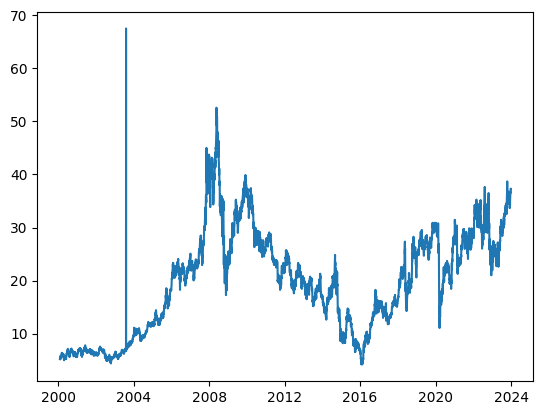

In [17]:
# Specify the ticker symbol for the stock you're interested in
# Example: Petrobras (PBR) listed in B3
ticker_symbol = "PETR4.SA"

# Download historical market data
data = yf.download(ticker_symbol, start="2000-02-01", end="2023-12-31")

# Display the data
plt.plot(data['Open'])

In [13]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-02-01,5.200000,5.200000,5.200000,5.200000,1.277316,23672320000
2000-02-02,5.300000,5.300000,5.300000,5.300000,1.301880,14272000000
2000-02-03,5.450000,5.450000,5.450000,5.450000,1.338726,25950720000
2000-02-04,5.588000,5.588000,5.588000,5.588000,1.372623,21199360000
2000-02-07,5.625000,5.625000,5.625000,5.625000,1.381713,20613120000
...,...,...,...,...,...,...
2023-12-21,36.669998,36.680000,36.070000,36.389999,33.925331,30511900
2023-12-22,36.500000,36.799999,36.369999,36.740002,34.251629,31234700
2023-12-26,36.860001,37.369999,36.830002,37.330002,34.801670,23466800


In [24]:
data.index

DatetimeIndex(['2000-02-01', '2000-02-02', '2000-02-03', '2000-02-04',
               '2000-02-07', '2000-02-08', '2000-02-09', '2000-02-10',
               '2000-02-11', '2000-02-14',
               ...
               '2023-12-14', '2023-12-15', '2023-12-18', '2023-12-19',
               '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-26',
               '2023-12-27', '2023-12-28'],
              dtype='datetime64[ns]', name='Date', length=6005, freq=None)

In [26]:
close = data['Close']

In [35]:
corr = []
lags = [30,60,120,365,600]
for lag in lags:
    cor = close.autocorr(lag=lag)
    corr.append(cor)
corr

[0.9525762353942578,
 0.908310209820466,
 0.8379710372661099,
 0.6982250757809518,
 0.4614000202532369]

In [ ]:
for i in len(data)-30:
    td= data.transpose().iloc[:,i-30:i]
    dt = td.transpose()

In [84]:
data[['Close']].transpose().iloc[:,0:30].values[0]

array([5.19999981, 5.30000019, 5.44999981, 5.58799982, 5.625     ,
       5.75      , 5.625     , 5.46299982, 5.28800011, 5.21299982,
       5.3130002 , 5.73799992, 5.6880002 , 5.5630002 , 5.55000019,
       5.5250001 , 5.5630002 , 5.71299982, 5.86299992, 5.75      ,
       5.7750001 , 5.875     , 5.83799982, 6.03800011, 6.03800011,
       6.03800011, 6.18100023, 6.39900017, 6.21299982, 6.21299982])

In [149]:
test = []
for i in range(0,30,3):
    test.append(i)

In [150]:
test

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [155]:
lags = 60
values = []
for i in range(0,len(data)-lags,lags):
    d = data['Close'].values[i:i+lags]
    values.append(d)

In [156]:
varray = np.array(values)
varrayT = varray.T
vdict = {f"t{i}": varrayT[i] for i in range(0, lags)}
df = pd.DataFrame(vdict)

In [167]:
len(df)

100

In [157]:
X = df.iloc[:,:40]
y = df.iloc[:,40:]
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=.2, shuffle=True)
gbm_obj = gbm(n_estimators=100,learning_rate=.1,random_state=42)
multi_output_gb = MultiOutputRegressor(gbm_obj)

multi_output_gb.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42))

In [158]:
y_pred = multi_output_gb.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 1.8803481077136344


In [160]:
y_predT = y_pred.T

In [161]:
y_predT.shape

(20, 20)

In [165]:
y_pred_df = pd.DataFrame({f"t{i+40}": y_predT[i] for i in range(0, 20)})

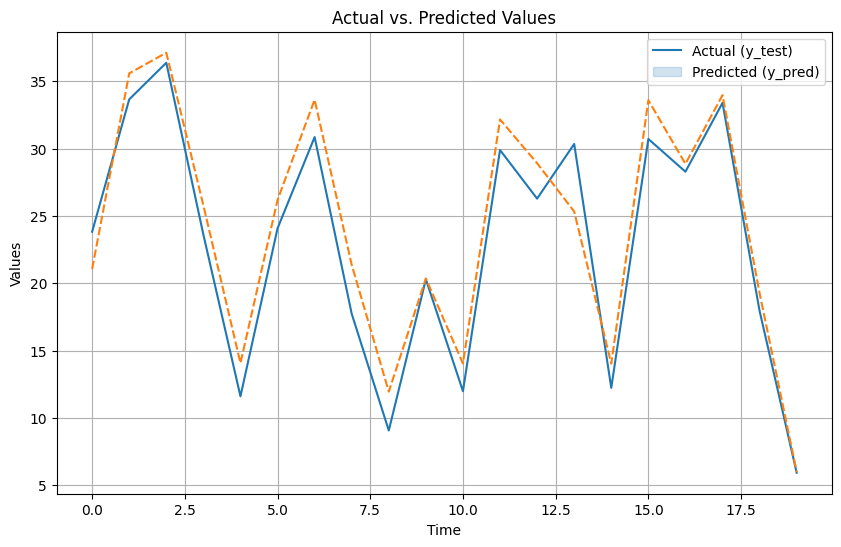

In [166]:
df2 = pd.DataFrame({'y_test': y_test['t59'].reset_index(drop=True), 'y_pred': y_pred_df['t59']})
plt.figure(figsize=(10, 6))
sns.lineplot(data=df2)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values')

# Display the plot
plt.legend(['Actual (y_test)', 'Predicted (y_pred)'])
plt.grid(True)
plt.show()